Resultados das Arquiteturas:
Arquitetura: (1, 32), Acurácia: 0.9567
Arquitetura: (1, 64), Acurácia: 0.9600
Arquitetura: (2, 32), Acurácia: 0.9400
Arquitetura: (2, 64), Acurácia: 0.9467
Arquitetura: (2, 64, 32), Acurácia: 0.9433
Arquitetura: (2, 32, 16), Acurácia: 0.9433


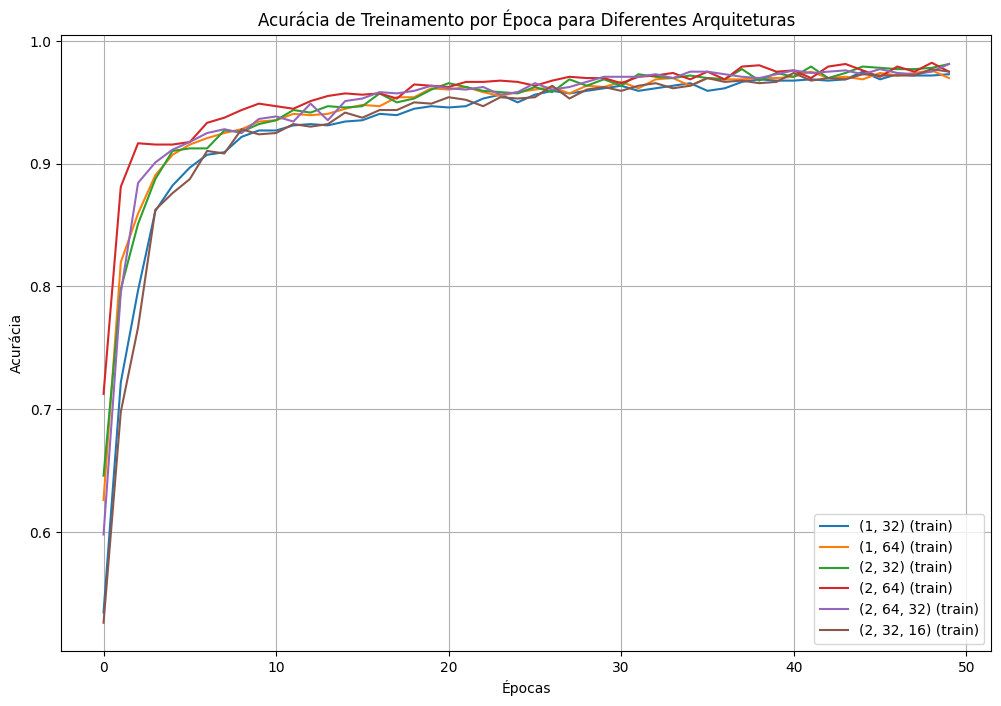

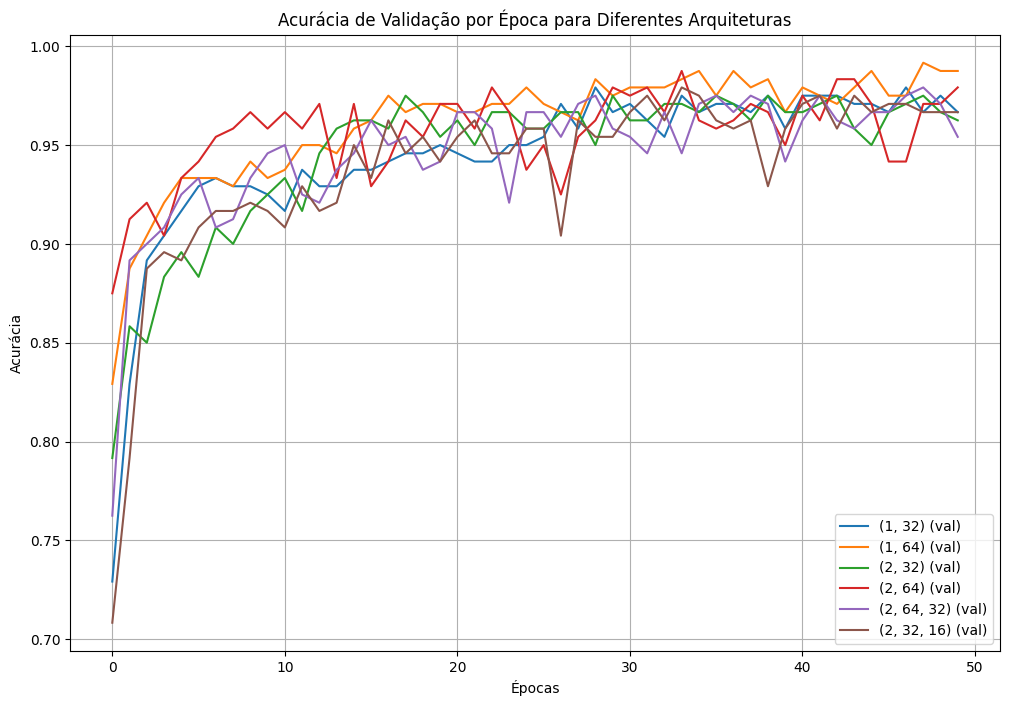

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
# Função para carregar e processar o dataset
def load_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Divide os valores por vírgulas
            values = list(map(float, line.strip().split(',')))
            data.append(values)
    
    data = np.array(data)
    
    # Extraindo features e labels (ignorando o índice)
    features = data[:, 1:-1]  # Ignora a primeira coluna (índice)
    labels = data[:, -1].astype(int)  # Última coluna são os rótulos, convertidos para inteiros
    
    # Subtraindo 1 de todos os rótulos (para que fiquem entre 0 e 3)
    labels = labels - 1
    
    # Normalizar os recursos (opcional)
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    
    # Determinar o número de classes dinamicamente
    num_classes = np.max(labels) + 1  # O número de classes é o maior rótulo + 1
    
    # Converter labels para one-hot encoding
    labels = to_categorical(labels, num_classes=num_classes)
    
    return features, labels

# Função para carregar dados sem rótulos
def load_features_only(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Divide os valores por vírgulas
            values = list(map(float, line.strip().split(',')))
            data.append(values)
    
    data = np.array(data)
    features = data[:, 1:]  # Ignorar a primeira coluna (índice)
    
    # Normalizar os recursos como no treinamento
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    
    return data[:, 0], features  # Retorna índices e features

# Exemplo de uso
file_path = "treino_sinais_vitais_com_label.txt"  # Substitua pelo caminho do arquivo .txt
features, labels = load_dataset(file_path)

# Dividir os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Função para construir, treinar e avaliar modelos
def evaluate_model(num_layers, neurons_per_layer):
    model = Sequential()
    model.add(Input(shape=(features.shape[1],)))  # Tamanho da entrada igual ao número de features

    # Adicionar camadas ocultas
    for _ in range(num_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))

    # Camada de saída
    model.add(Dense(labels.shape[1], activation='softmax'))

    # Compilar o modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, verbose=0)

    # Avaliar o modelo nos dados de teste
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy, history

# Comparar diferentes arquiteturas
results = []
architectures = [
    (1, 32),  # 1 camada oculta com 32 neurônios
    (1, 64),  # 1 camada oculta com 64 neurônios
    (2, 32),  # 2 camadas ocultas com 32 neurônios cada
    (2, 64),  # 2 camadas ocultas com 64 neurônios cada
    (2, 64, 32),  # 2 camadas ocultas com 64 e 32 neurônios
    (2, 32, 16),  # 2 camadas ocultas com 32 e 16 neurônios
]

all_histories = []
# Configurar uma taxa de aprendizado personalizada
learning_rate = 0.01  # Exemplo de taxa de aprendizado
# Compilar o modelo com a nova taxa de aprendizado


for architecture in architectures:
    if len(architecture) == 2:
        num_layers, neurons = architecture
        accuracy, history = evaluate_model(num_layers, neurons)
    else:
        num_layers, *neurons = architecture
        model = Sequential()
        model.add(Input(shape=(features.shape[1],)))  # Tamanho da entrada igual ao número de features
        for n in neurons:
            model.add(Dense(n, activation='relu'))
        model.add(Dense(labels.shape[1], activation='softmax'))
        model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append((*architecture, accuracy))
    all_histories.append((architecture, history))

# Exibir os resultados
print("Resultados das Arquiteturas:")
for architecture in results:
    print(f"Arquitetura: {architecture[:-1]}, Acurácia: {architecture[-1]:.4f}")

# Salvar os resultados em um arquivo
with open("model_comparison_results.txt", 'w') as f:
    for architecture in results:
        f.write(f"Arquitetura: {architecture[:-1]}, Acurácia: {architecture[-1]:.4f}\n")

# Gerar gráficos de acurácia por época (separados para treino e validação)
plt.figure(figsize=(12, 8))
for architecture, history in all_histories:
    plt.plot(history.history['accuracy'], label=f"{architecture} (train)")
plt.title("Acurácia de Treinamento por Época para Diferentes Arquiteturas")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.savefig("train_accuracy_per_epoch.png")
plt.show()

plt.figure(figsize=(12, 8))
for architecture, history in all_histories:
    plt.plot(history.history['val_accuracy'], label=f"{architecture} (val)")
plt.title("Acurácia de Validação por Época para Diferentes Arquiteturas")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.savefig("val_accuracy_per_epoch.png")
plt.show()